计算验证集内粒子标注点的最短间距是多少

In [2]:
import numpy as np
import mmcv
import matplotlib.pyplot as plt

import json
from pycocotools.coco import COCO

In [3]:
img_path = '/root/mmyolo/data/coco/val2017/1.jpg'
json_path = '/root/mmyolo/data/coco/annotations/instances_val2017.json'

with open(json_path) as f:
    data = json.load(f)

coco = COCO(json_path)

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [4]:
ori_img = mmcv.imread(img_path)
anno_ids = coco.getAnnIds(imgIds=0)
annos = coco.loadAnns(anno_ids)

提取annos内'bbox'的信息

In [5]:
instances = []
for _ in annos:
    instances.append(_['bbox'])
instances = np.array(instances)

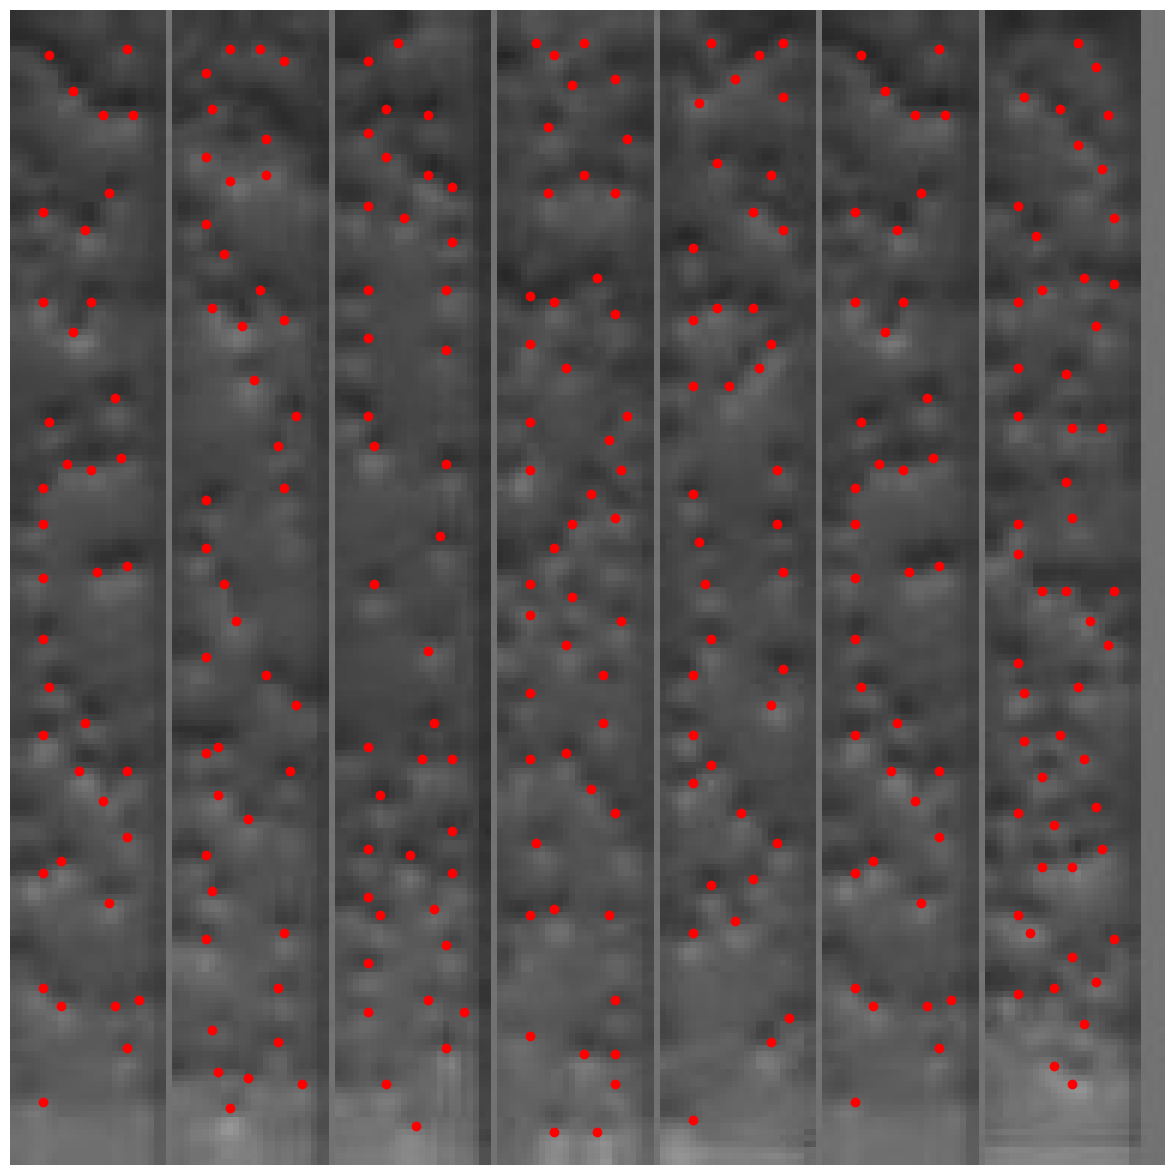

In [6]:
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(ori_img)
plt.scatter(instances[:, 0] + 5, instances[:, 1] + 5, color='red', marker='o')

In [7]:
def cal_distance(points):
    # 计算点到点的距离
    distances = np.linalg.norm((points[:, np.newaxis] - points), axis=2)

    # 因为对角线是0, 忽略对角线的值, 将对角线元素设为无穷大
    np.fill_diagonal(distances, np.inf)
    # 计算每个点离最近的点的距离
    nearest = np.min(distances, axis=1)
    # print(np.min(nearest))
    # 统计距离小于采样率8的点有多少
    count = np.count_nonzero(nearest <= 8)
    return nearest, count

img_size = (192, 192)下的情况

In [8]:
points = np.array(instances[:, :2])
# 移到中心点
points = points + 5

nearest, count = cal_distance(points)
print(count)

249


img_size = (320, 320)下的情况

In [9]:
def resize_img(img, scale):
    scaled_img, scale_factor = mmcv.imrescale(img, (scale, scale), interpolation='bilinear', return_scale=True, backend='cv2')

    return scaled_img, scale_factor

def resize_bbox(bboxes, scale_factor):
    bboxes = bboxes * np.tile(np.array(scale_factor), 2)
    return bboxes

In [10]:
sclaed_img, scale_factor = resize_img(ori_img, 320)

In [11]:
# 为了对bboxes缩放, 要将instances转换成xyxy的形式
def xywh2xyxy(bboxes):
    x, y, w, h = bboxes[:, 0], bboxes[:, 1], bboxes[:, 2], bboxes[:, 3]
    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h
    return np.column_stack((x1, y1, x2, y2))

bboxes = xywh2xyxy(instances)
bboxes = resize_bbox(bboxes, (scale_factor, scale_factor))

# 获取中心点
cx = np.mean(bboxes[:, [0, 2]], axis=1)
cy = np.mean(bboxes[:, [1, 3]], axis=1)

nearest, count = cal_distance(np.column_stack((cx, cy)))
print(count)
print(nearest[nearest <= 8])

46
[6.87184271 6.87184271 6.00925213 6.00925213 7.07106781 7.07106781
 6.87184271 6.87184271 3.72677996 3.72677996 7.45355992 7.45355992
 7.45355992 7.45355992 6.00925213 6.00925213 6.00925213 6.00925213
 6.87184271 6.87184271 6.87184271 6.87184271 7.45355992 7.45355992
 7.45355992 7.45355992 7.45355992 7.45355992 7.07106781 7.07106781
 6.87184271 6.87184271 6.00925213 6.00925213 7.07106781 7.07106781
 6.87184271 6.87184271 7.45355992 7.45355992 6.66666667 6.66666667
 6.00925213 6.00925213 7.07106781 7.07106781]


(320, 320)下大部分间距小于8的点距离也在6到7左右, 因为最后是判断IOU>0.5的就算预测到, 这种情况在8倍下采样时, 如果特征图上相邻的点回归的bbox是有可能IOU满足的, 所以(320, 320)下对精度的影响就不大了. 

(640, 640)下的情况

In [12]:
sclaed_img, scale_factor = resize_img(ori_img, 640)
bboxes = xywh2xyxy(instances)
bboxes = resize_bbox(bboxes, (scale_factor, scale_factor))

# 获取中心点
cx = np.mean(bboxes[:, [0, 2]], axis=1)
cy = np.mean(bboxes[:, [1, 3]], axis=1)

nearest, count = cal_distance(np.column_stack((cx, cy)))
print(count)

2
